In [27]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import shutil
import matplotlib.pyplot as plt

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import os

dataset_path = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal images UL"
print("Does dataset exist?", os.path.exists(dataset_path))
print("Folders inside:", os.listdir(dataset_path) if os.path.exists(dataset_path) else "Path not found!")


Does dataset exist? True
Folders inside: ['Read Me - Oryza sativa - TImages.docx', 'healthy', 'Blast', 'BLB', 'hispa', 'leaf folder', 'leaf spot']


In [30]:
source_dir = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal images UL"
output_dir = "/content/drive/MyDrive/Colab Notebooks/thermal_images/thermal images UL"


classes = ['Blast', 'BLB', 'healthy', 'hispa', 'leaf folder', 'leaf spot']


In [31]:
# Step 1: Data Preparation
def prepare_data(source_dir, output_dir, classes, test_size=0.2, val_size=0.2):
    """Prepare the dataset by splitting it into training, validation, and test sets."""
    splits = ['train', 'validation', 'test']

    # Create directories for splits
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_dir, split, cls), exist_ok=True)

    # List all images and split data
    for cls in classes:
        class_dir = os.path.join(source_dir, cls)
        images = [os.path.join(class_dir, img) for img in os.listdir(class_dir) if img.endswith(('jpg', 'png'))]

        # Split into train, validation, and test sets
        train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)
        train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

        # Copy images to respective directories
        for img_path in train_images:
            shutil.copy(img_path, os.path.join(output_dir, 'train', cls))
        for img_path in val_images:
            shutil.copy(img_path, os.path.join(output_dir, 'validation', cls))
        for img_path in test_images:
            shutil.copy(img_path, os.path.join(output_dir, 'test', cls))

    print("Dataset preparation complete.")

In [32]:
# Prepare dataset
prepare_data(source_dir, output_dir, classes)

Dataset preparation complete.


In [33]:
# Step 2: Create Data Generators
def create_data_generators(output_dir, img_size=(224, 224), batch_size=32):
    datagen_train = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    datagen_val_test = ImageDataGenerator(rescale=1./255)

    train_generator = datagen_train.flow_from_directory(
        os.path.join(output_dir, 'train'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'validation'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = datagen_val_test.flow_from_directory(
        os.path.join(output_dir, 'test'),
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return train_generator, val_generator, test_generator

In [34]:
# Create data generators
train_gen, val_gen, test_gen = create_data_generators(output_dir)

Found 403 images belonging to 6 classes.
Found 104 images belonging to 6 classes.
Found 129 images belonging to 6 classes.


In [35]:
# Step 3: Build AlexNet Model
def build_alexnet_model(input_shape=(224, 224, 3), num_classes=6):
    """Build an AlexNet model for classification."""
    model = models.Sequential([
        layers.Conv2D(96, kernel_size=(11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(256, kernel_size=(5, 5), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(384, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),

        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [36]:
# Build the model
model = build_alexnet_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
# Step 4: Train the Model
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 98s 7s/step - accuracy: 0.2928 - loss: 1.7104 - val_accuracy: 0.3462 - val_loss: 1.6213 - learning_rate: 1.0000e-04
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 135s 7s/step - accuracy: 0.3758 - loss: 1.5901 - val_accuracy: 0.3654 - val_loss: 1.5441 - learning_rate: 1.0000e-04
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.3867 - loss: 1.5603 - val_accuracy: 0.4231 - val_loss: 1.4333 - learning_rate: 1.0000e-04
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 81s 6s/step - accuracy: 0.4770 - loss: 1.4126 - val_accuracy: 0.4615 - val_loss: 1.3445 - learning_rate: 1.0000e-04
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.4295 - loss: 1.4104 - val_accuracy: 0.4904 - val_loss: 1.2748 - learning_rate: 1.0000e-04
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 79s 6s/step - accuracy: 0.4835 - loss: 1.3196 - val_accuracy: 0.5096 - val_loss: 1.2407 - learning_rate: 1.0000e-04
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 88s 7s/step - accuracy: 0.4622 - loss

In [38]:
eval_results = model.evaluate(test_gen)
print(f"Test Accuracy: {eval_results[1] * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 886ms/step - accuracy: 0.7420 - loss: 0.7429
Test Accuracy: 72.09%


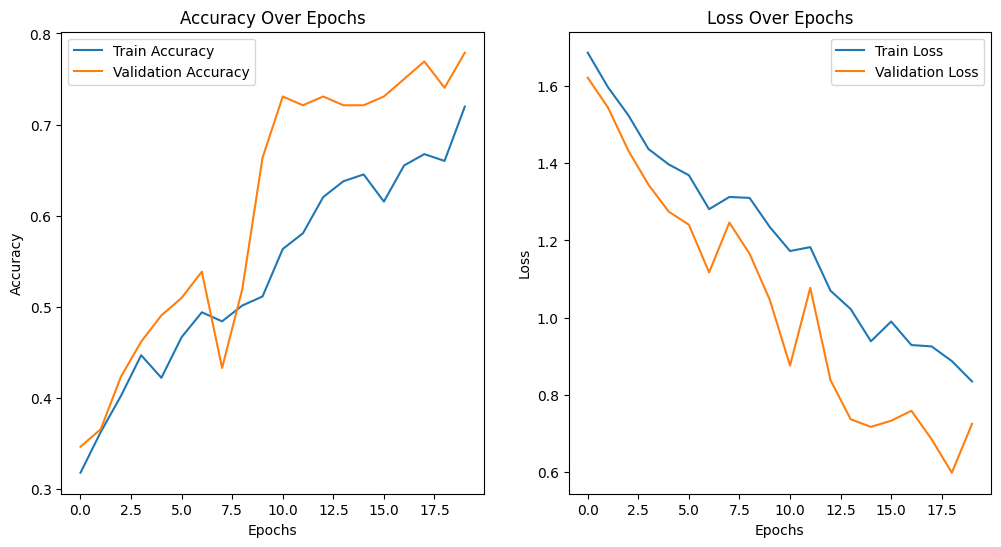

In [39]:
# Step 6: Plot Training and Validation Accuracy and Loss
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)

In [40]:
# Save the model
model.save("AlexNet.h5")
print("Model saved.")

Model saved.
